##Dataset

In [ ]:
import gdown
import os
import pandas as pd
from google.colab import drive
# part 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
## برای سوال دوم
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import pickle
import gc
##  بخش سوم
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
file_urls = {
    "train_data.csv": "https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW",
    "test_data.csv": "https://drive.google.com/uc?id=1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB",
    "product_mapping.csv": "https://drive.google.com/uc?id=1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h"
}

drive.mount('/content/drive')

shared_dir = "/content/drive/MyDrive/Bootcamp"
os.makedirs(shared_dir, exist_ok=True)

for file_name, url in file_urls.items():
    output_path = os.path.join(shared_dir, file_name)
    gdown.download(url, output_path, quiet=False)
    print(f"فایل {file_name} در {shared_dir} ذخیره شد.")

notebook_name = "project2.ipynb"
notebook_path = os.path.join(shared_dir, notebook_name)
print(f"\nنوت‌بوک در {notebook_path} ذخیره خواهد شد.")

print("\nفایل‌های موجود در پوشه مشترک:")
for file in os.listdir(shared_dir):
    if file.endswith((".csv", ".ipynb")):
        print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From (original): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
From (redirected): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW&confirm=t&uuid=221e6953-924d-47aa-9a02-70b10523c748
To: /content/drive/MyDrive/Bootcamp/train_data.csv
100%|██████████| 635M/635M [00:13<00:00, 48.0MB/s]


فایل train_data.csv در /content/drive/MyDrive/Bootcamp ذخیره شد.


Downloading...
From: https://drive.google.com/uc?id=1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB
To: /content/drive/MyDrive/Bootcamp/test_data.csv
100%|██████████| 15.6M/15.6M [00:00<00:00, 97.8MB/s]


فایل test_data.csv در /content/drive/MyDrive/Bootcamp ذخیره شد.


Downloading...
From: https://drive.google.com/uc?id=1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h
To: /content/drive/MyDrive/Bootcamp/product_mapping.csv
100%|██████████| 97.3M/97.3M [00:03<00:00, 28.3MB/s]

فایل product_mapping.csv در /content/drive/MyDrive/Bootcamp ذخیره شد.

نوت‌بوک در /content/drive/MyDrive/Bootcamp/project2.ipynb ذخیره خواهد شد.

فایل‌های موجود در پوشه مشترک:
bert_labeled_data.csv
updated_label_data.csv
test_data.csv
train_data.csv
product_mapping.csv
quick_warranty_sentiment.csv


In [ ]:
print("\nنمونه‌ای از train_data.csv:")
df_train = pd.read_csv(os.path.join(shared_dir, "train_data.csv"), nrows=5)
print(df_train.head())


نمونه‌ای از train_data.csv:
   overall  vote  verified  reviewTime      reviewerID       asin  style  \
0        2   NaN     False  2016-11-11   A2OSUEZJIN7BI  511189877    NaN   
1        5   NaN      True  2016-06-06  A2NETQRG6JHIG7  511189877    NaN   
2        4   NaN      True  2016-03-10  A12JHGROAX49G7  511189877    NaN   
3        5   NaN      True  2016-01-14  A1KV65E2TMMG6F  511189877    NaN   
4        5   NaN      True  2016-10-20  A280POPEWI0NSA  594459451    NaN   

    reviewerName                                         reviewText  \
0          Chris  I have an older URC-WR7 remote and thought thi...   
1   Qrysta White  First time I've EVER had a remote that needed ...   
2        Linwood  Got them and only 2 of them worked. company ca...   
3  Dane Williams  I got tired of the remote being on the wrong s...   
4    Kristina H.  After purchasing cheap cords from another webs...   

                               summary  unixReviewTime  
0                         Cann

## Part 1

### 1- توزیع ستون overall

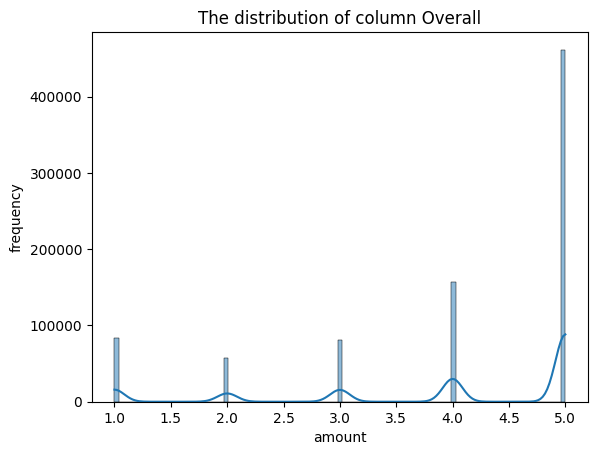

In [ ]:
sns.histplot(df_train['overall'], kde=True)
plt.title('The distribution of column Overall')
plt.xlabel('amount')
plt.ylabel('frequency')
plt.show()

### 2-Word Cloud

In [ ]:
# دانلود منابع NLTK
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# تعریف دسته‌ها بر اساس ستون overall
positive = df_train[df_train['overall'].isin([4, 5])]['reviewText']
neutral = df_train[df_train['overall'] == 3]['reviewText']
negative = df_train[df_train['overall'].isin([1, 2])]['reviewText']

# دریافت stop words انگلیسی
stop_words = set(stopwords.words('english'))
# stop_words.update(['would', 'get', 'one']) ## اضافه کردن کلمات زائد به مجموعه

# ایجاد شیء Lemmatizer
lemmatizer = WordNetLemmatizer()

# این تابع کلمات با ریشه یکسان را به ریشه بر می گرداند
def lemmatize_word(word):
    # اول فرم فعل آن  را چک می کنیم
    lemma = lemmatizer.lemmatize(word, pos='v')
    if lemma == word:  # اگر کلمه فرم فعل نداشت فرم اسم را امتحان می کنیم
        lemma = lemmatizer.lemmatize(word, pos='n')
    if lemma == word:  # اگر فرم اسم هم نداشت فرم صفت را امتحان می کنیم
        lemma = lemmatizer.lemmatize(word, pos='a')
    return lemma

# تابع بهینه‌شده برای پیش‌پردازش متن با استفاده از Counter
def preprocess_text(text_series):
    word_counts = Counter()
    for text in text_series:
        if isinstance(text, str):  # بررسی اینکه متن رشته باشد
            # توکن‌سازی
            tokens = word_tokenize(text.lower())
            # لماتیزه کردن و حذف stop words و کاراکترهای غیرحروفی
            tokens = [lemmatize_word(word) for word in tokens if word.isalnum() and word not in stop_words]
            # به‌روزرسانی شمارش کلمات
            word_counts.update(tokens)

        # gc.collect() # آزادسازی حافظه
    return word_counts

# پیش‌پردازش متن برای هر دسته
print('processing positive_words...')
positive_words = preprocess_text(positive)
print('positive_words Completed', '\n processing neutral_words...')
neutral_words = preprocess_text(neutral)
print('neutral_words Completed', '\n processing negative_words...')
negative_words = preprocess_text(negative)
print('negative_words Completed')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\win10\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win10\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\win10\AppData\Roaming\nltk_data...


processing positive_words...
positive_words Completed 
 processing neutral_words...
neutral_words Completed 
 processing negative_words...
negative_words Completed


<div dir="rtl">
بخش ذخیره و بازیابی استخراج کلمات
</div>

In [ ]:
with open('positive_word_counts.pkl', 'wb') as file:
    pickle.dump(positive_words, file)
print("positive_words در فایل 'positive_word_counts.pkl' ذخیره شد.")

with open('neutral_word_counts.pkl', 'wb') as file:
    pickle.dump(neutral_words, file)
print("neutral_words در فایل 'neutral_word_counts.pkl' ذخیره شد.")

with open('negative_word_counts.pkl', 'wb') as file:
    pickle.dump(negative_words, file)
print("negative_words در فایل 'negative_word_counts.pkl' ذخیره شد.")

positive_words در فایل 'positive_word_counts.pkl' ذخیره شد.
neutral_words در فایل 'neutral_word_counts.pkl' ذخیره شد.
negative_words در فایل 'negative_word_counts.pkl' ذخیره شد.


In [ ]:
# بازیابی positive_word_counts از فایل Pickle
with open('positive_word_counts.pkl', 'rb') as file:
    loaded_positive_word_counts = pickle.load(file)

<div dir="rtl">
نمایش نتیجه
</div>

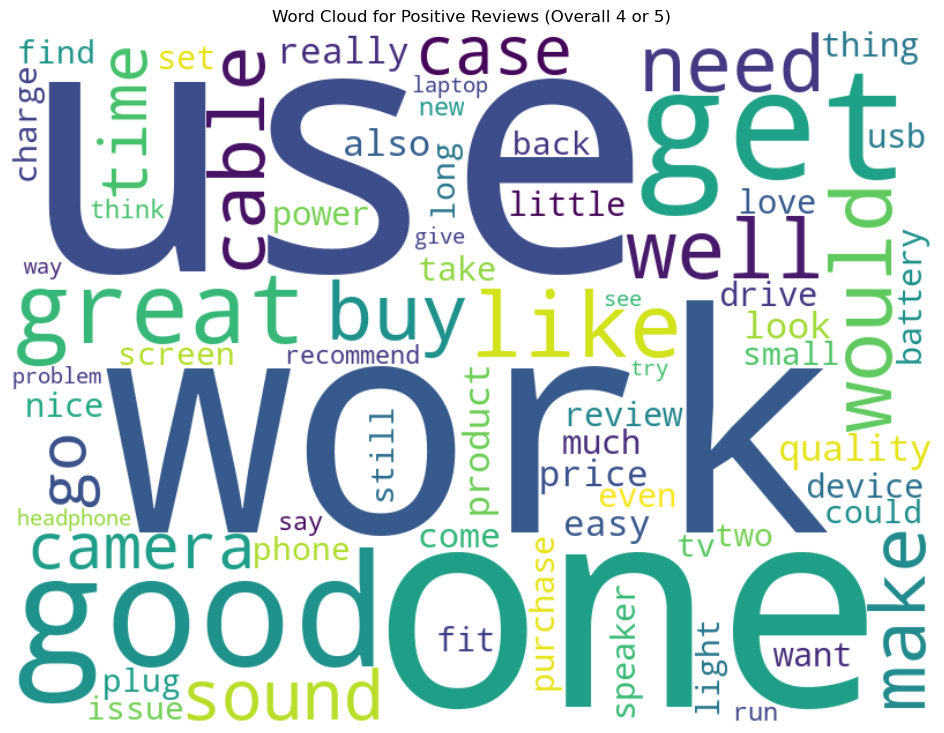

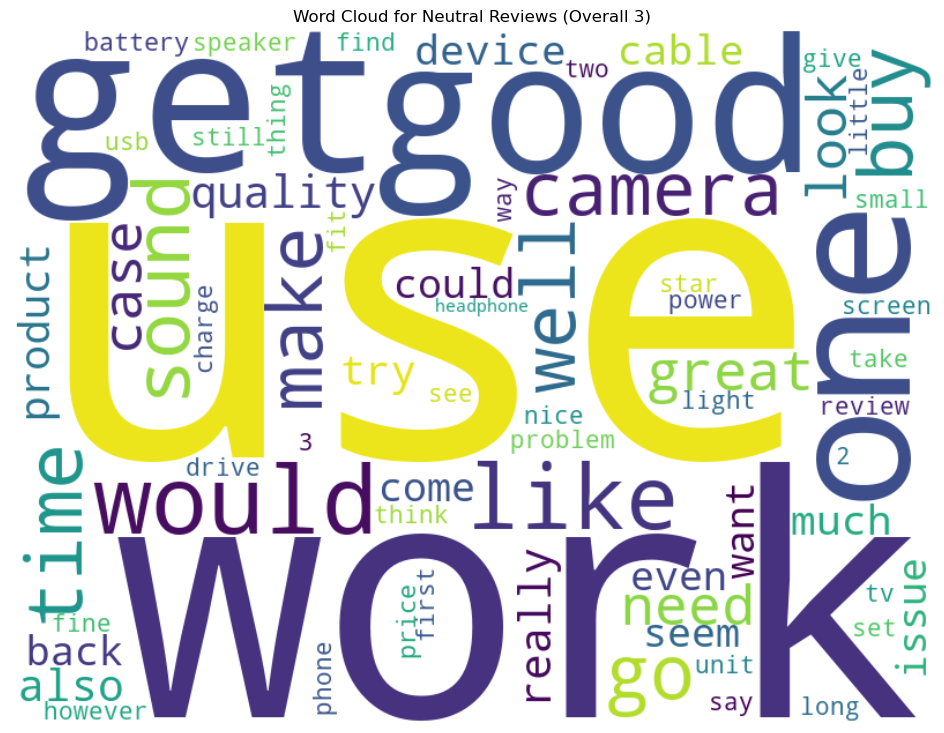

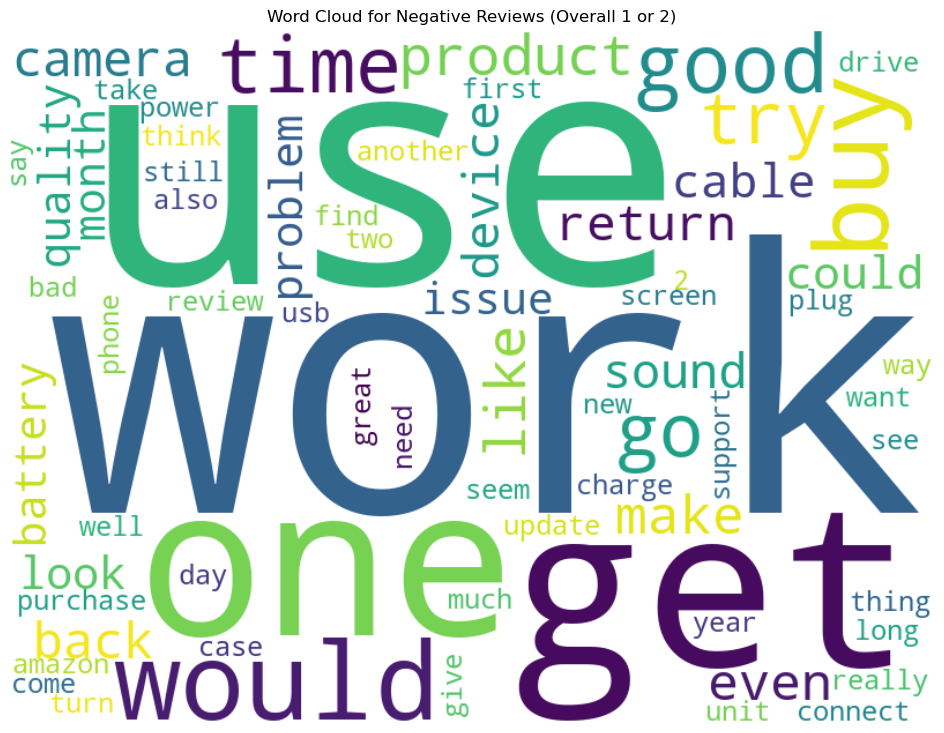

In [ ]:
# تابع برای رسم ابر کلمات با تنظیمات بهینه
def plot_wordcloud(word_counts, title):
    # محدود کردن تعداد کلمات و اندازه تصویر
    wordcloud = WordCloud(width=800, height=600, background_color='white', max_words=70).generate_from_frequencies(word_counts)
    plt.figure(figsize=(12, 9))  # اندازه کوچکتر
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
    # آزادسازی حافظه
    gc.collect()


# رسم ابر کلمات برای هر دسته
plot_wordcloud(positive_words, 'Word Cloud for Positive Reviews (Overall 4 or 5)')
plot_wordcloud(neutral_words, 'Word Cloud for Neutral Reviews (Overall 3)')
plot_wordcloud(negative_words, 'Word Cloud for Negative Reviews (Overall 1 or 2)')

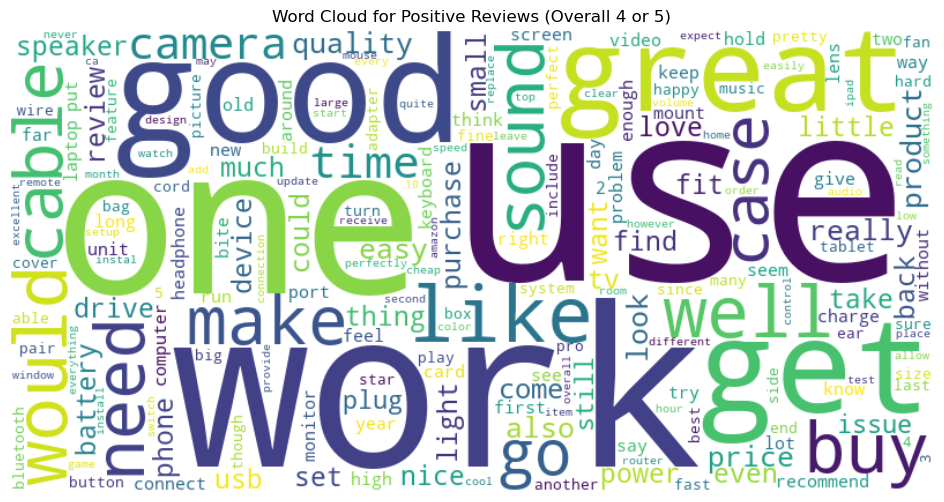

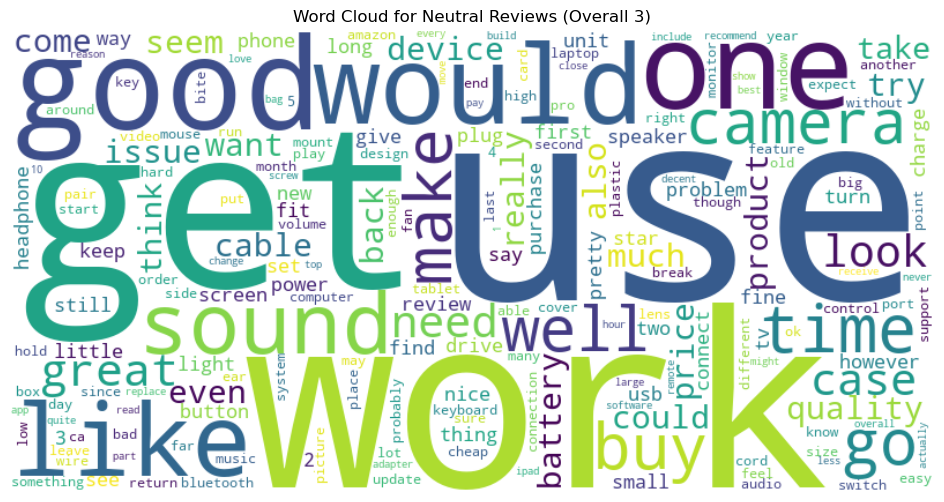

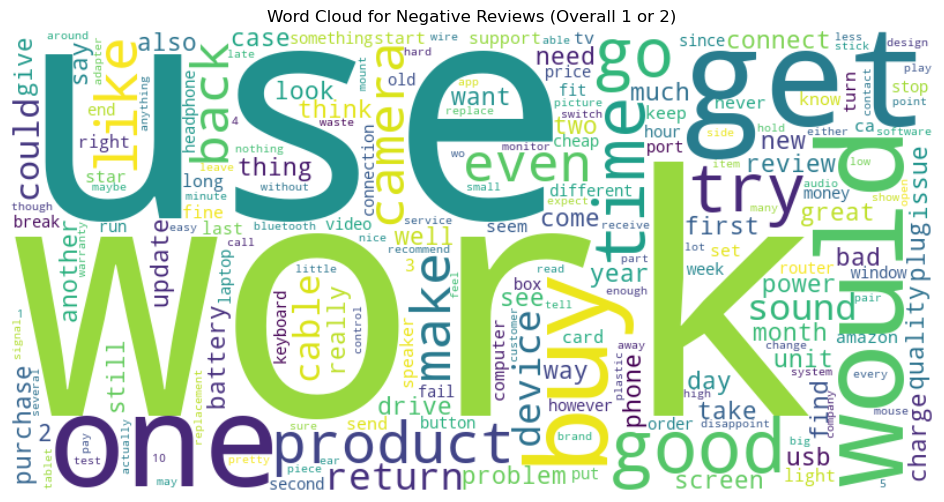

In [ ]:
# تابع برای رسم ابر کلمات با تنظیمات بهینه
def plot_wordcloud(word_counts, title):
    # محدود کردن تعداد کلمات و اندازه تصویر
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate_from_frequencies(word_counts)
    plt.figure(figsize=(12, 6))  # اندازه کوچکتر
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
    # آزادسازی حافظه
    gc.collect()


# رسم ابر کلمات برای هر دسته
plot_wordcloud(positive_words, 'Word Cloud for Positive Reviews (Overall 4 or 5)')
plot_wordcloud(neutral_words, 'Word Cloud for Neutral Reviews (Overall 3)')
plot_wordcloud(negative_words, 'Word Cloud for Negative Reviews (Overall 1 or 2)')

In [ ]:
# یافتن کلمات پرتکرار و اشتراک بین دسته‌های مثبت و منفی
positive_freq = Counter(positive_words)
negative_freq = Counter(negative_words)

# کلمات پرتکرار (مثلاً ۵ کلمه برتر)
print("Top 5 words in Positive Reviews:", positive_freq.most_common(5))
print("Top 5 words in Negative Reviews:", negative_freq.most_common(5))

# یافتن اشتراک کلمات
common_words = set(positive_freq.keys()).intersection(set(negative_freq.keys()))
print("Common words between Positive and Negative Reviews:", common_words)

Top 5 words in Positive Reviews: [('use', 511874), ('work', 373123), ('one', 323093), ('good', 315322), ('get', 311398)]
Top 5 words in Negative Reviews: [('work', 109418), ('use', 90923), ('get', 87779), ('one', 76387), ('would', 64777)]
Common words between Positive and Negative Reviews: {'rudder', 'amicably', 'differentiate', '2209', 'se42ums', 'spotiy', 'grocery', 'intentioned', 'serrate', 'extra', 'attenuation', 'zir32', 'pe60', 'disreputable', 'familiar', 'codger', 'eyelid', 'decisive', 'zuni', 'boomerang', '633xs', 'frog', 'ill', 'exclude', 'channals', 'xt912', 'expend', 'firstvision', 'linkage', 'actiontek', 'delta', 'shippable', 'psyched', 'dissimilar', 'carls', 'hyperscrolling', 'stiched', 'beg', '40fs3800', 'arabic', '78se', 'a1465', 'unspools', 'pinzon', '45mb', 'parallax', 'storefront', 'cohort', '500gbs', 'dpx501bt', '2amp', 'numerical', 'fudge', 'blinker', 'phd', 'swimmingly', 'mb42s', 'expensive', 'bifrost', 'impatience', 'd7500', '1153e', '186', '197', '19c', 'avaiable

In [ ]:
del positive, neutral, negative, positive, neutral, negative

### 3-مجموع نظرات هر فرد

In [ ]:
df_train.vote.fillna(0.0) ##
df_train.vote = pd.to_numeric(df_train.vote, errors='coerce')
top_users = df_train.groupby(['reviewerID', 'reviewerName'])['vote'].sum().reset_index()

top_users.sort_values(by='vote', ascending=False).head(10)

,reviewerID,reviewerName,vote
98734,A25GROL6KJV3QG,Benson Leung,4572.0
129947,A2IK776FY6MEMG,Obi Wan,1608.0
24237,A1A39899KH5QCI,Chris Winter,1352.0
293333,AMYCUX8EWEUVV,Mayra S.,1342.0
261382,A9K7V1MKJ9BOJ,VermontGuy,1337.0
73232,A1UQUDT2Q0YENM,Michael,1230.0
235609,A3R1WFO4KIUQXZ,PhotoGraphics,1209.0
169646,A2Z9APP5B09MFY,Nicholas,1188.0
296757,AOEAD7DPLZE53,NLee the Engineer,1103.0
323642,AZPCDY9OQ605E,David H,1045.0


### 4-reviewText Histogram

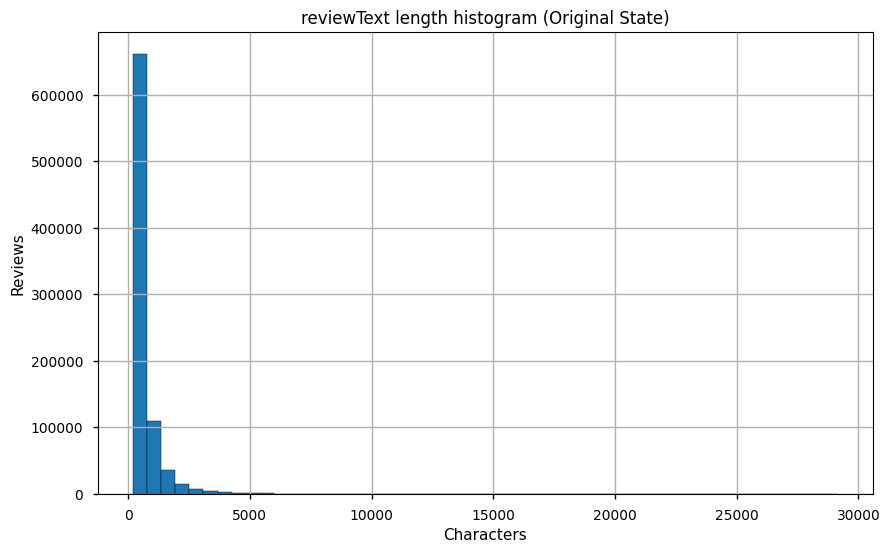

In [ ]:
df_train['text_length'] = df_train['reviewText'].str.len() ## اضافه کردن ستون هر متن

# تنظیمات برای نمایش بهتر نمودارها
plt.style.use('seaborn-v0_8-notebook')  # برای ظاهری خوانا

# ۱. هیستوگرام حالت اصلی
plt.figure(figsize=(10, 6))
plt.hist(df_train['text_length'], bins=50, edgecolor='black')
# sns.histplot(df_train['text_length'], kde=True)
plt.title('reviewText length histogram (Original State)')
plt.xlabel('Characters')
plt.ylabel('Reviews')
plt.grid(True)
plt.show()

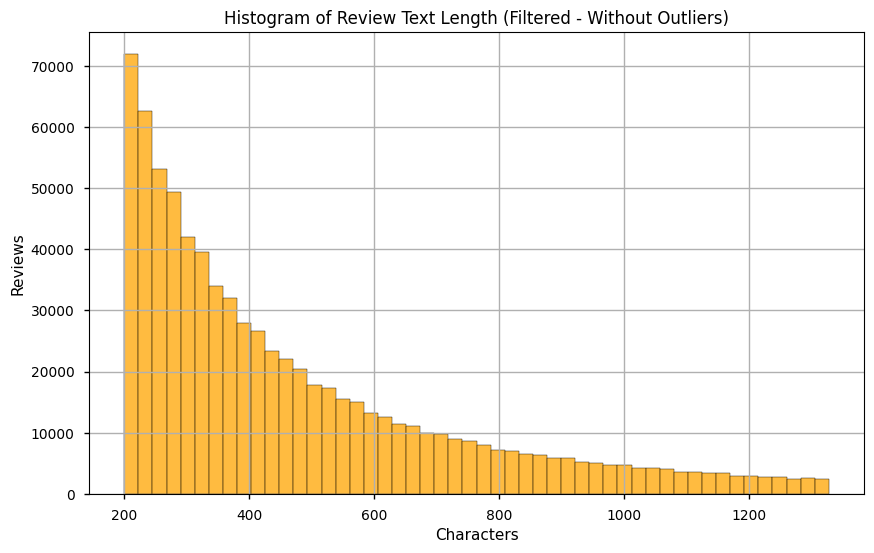

In [ ]:
# فیلتر پرت‌ها
Q1 = df_train['text_length'].quantile(0.25)
Q3 = df_train['text_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = df_train[(df_train['text_length'] >= lower_bound) & (df_train['text_length'] <= upper_bound)]

# هیستوگرام حالت فیلترشده
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['text_length'], bins=50, kde=False, edgecolor='black', color='orange')
plt.title('Histogram of Review Text Length (Filtered - Without Outliers)')
plt.xlabel('Characters')
plt.ylabel('Reviews')
plt.grid(True)
plt.show()

<div dir='rtl'>
کمتر از 100 هزار نظر پرت دارد
</h4>

In [ ]:
# نمایش آمار توصیفی
print("آمار توصیفی طول متن (حالت اصلی):")
print(df_train['text_length'].describe())
print("\nآمار توصیفی طول متن (حالت فیلترشده):")
print(filtered_df['text_length'].describe())

آمار توصیفی طول متن (حالت اصلی):
count    838944.000000
mean        624.687384
std         684.129474
min         200.000000
25%         277.000000
50%         408.000000
75%         697.000000
max       29146.000000
Name: text_length, dtype: float64

آمار توصیفی طول متن (حالت فیلترشده):
count    767663.000000
mean        469.759015
std         260.917106
min         200.000000
25%         269.000000
50%         380.000000
75%         592.000000
max        1327.000000
Name: text_length, dtype: float64


### 5-Most 5-Star Reviews

In [ ]:
## پیوند دیتافریم آموزشی با دیتافریم عنوان و برند
df_merge = df_train.merge(title_brand, on='asin', how='left')

## نظرات با امتیاز 5
five_star_reviews = df_merge[df_merge['overall'] == 5]

## گروه بندی بر اساس عنوان و برند
top_products = five_star_reviews.groupby(['brand', 'title']).size().reset_index(name='five_star_count')

## نمایش 10 محصول برتر
top_products.sort_values(by='five_star_count', ascending=False).head(10)

,brand,title,five_star_count
10992,Cambridge Soundworks,OontZ Angle 3 Enhanced Stereo Edition IPX5 Spl...,1163
39460,NETGEAR,NETGEAR N300 WiFi Range Extender (EX2700),659
49185,Roku,Roku Streaming Stick (3600R) - HD Streaming Pl...,600
56451,StarTech,StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...,598
34377,Logitech,Logitech M570 Wireless Trackball Mouse &ndash;...,552
51240,Samsung,Samsung 850 EVO 500GB 2.5-Inch SATA III Intern...,529
39416,NETGEAR,NETGEAR 5-Port Gigabit Ethernet Unmanaged Swit...,482
5073,Asus,ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up...,471
63425,VideoSecu,VideoSecu ML531BE TV Wall Mount for Most 27&qu...,448
12377,Cheetah,Cheetah Mounts APFMSB TV Wall Mount Bracket fo...,434


### 6-Top 10 Brand

In [ ]:
## برند با بیشترین نظرات
''' چون هر رکورد جدول حتما یکی در مورد یکی از محصولات است و هر محصول یک برند دارد'''
top_brands = df_merge['brand'].value_counts().head(10).index

## فیلتر دیتافریم: تنها رکوردهایی که برند آنها در متغییر بالا آمده باشد
top_brands_df = df_merge[df_merge['brand'].isin(top_brands)]

## میانگین امتیاز هر برند
top_brands_df = top_brands_df.groupby('brand')['overall'].mean().reset_index(name='average_rating')
top_brands_df = top_brands_df.sort_values(by='average_rating', ascending=False)

## نمایش نتیجه
top_brands_df

,brand,average_rating
1,Anker,4.244320
0,AmazonBasics,4.201468
5,Sabrent,4.028005
7,SanDisk,3.958810
3,Logitech,3.954061
6,Samsung,3.941268
8,Sony,3.938726
9,TP-LINK,3.928681
2,Asus,3.855550
4,NETGEAR,3.836274
